## 1. Data Preprocessing

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn import tree
from sklearn.metrics import confusion_matrix, f1_score,precision_score
from datetime import datetime
# from sklearn.metrics.ConfusionMatrixDisplay import from_predictions
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
# for the operating system operations e.g., creating a folder.

# Tensorflow and Keras are two packages for creating neural network models.
import tensorflow as tf
from tensorflow import keras
# import NN layers and other componenets.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, LSTM, Flatten
from tensorflow.keras import optimizers
import seaborn as sns # for plotting.


In [51]:
# Make sure to change the path to your local directory
weather_data = pd.read_csv('C:/Users/vchalla2/Downloads/ECONet/train.csv')
df = weather_data

from sklearn.preprocessing import LabelEncoder
#Encoding non-traditional features
le = LabelEncoder()
df.Station = le.fit_transform(df.Station)
df.measure = le.fit_transform(df.measure)
df['target'] = le.fit_transform(df['target'])
#converting time series to numeric and performed encoding on station,measure 
df['Ob'] = pd.to_numeric(pd.to_datetime(df['Ob']))

# from sklearn.preprocessing import StandardScaler
# scaling = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
df.value= scaling.fit_transform(df[['value']])

normalized = df[{'value', 'measure'}].groupby('measure').transform(lambda x: (x - x.mean()) / x.std())
df.value = normalized['value']
df


C:\Users\vchalla2\AppData\Local\Temp\ipykernel_14208\592692043.py:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  normalized = df[{'value', 'measure'}].groupby('measure').transform(lambda x: (x - x.mean()) / x.std())


Station                   Ob     value  measure  target  R_flag  \
0              0  1609547400000000000  1.559719       12       0       2   
1              0  1609561800000000000  1.626475       12       0       2   
2              0  1609565400000000000  1.593097       12       0       2   
3              0  1609572600000000000  1.481837       12       0       2   
4              0  1613442600000000000  1.392829       12       0       2   
...          ...                  ...       ...      ...     ...     ...   
6593269       42  1617431160000000000  0.308517        0       0       4   
6593270       42  1617431220000000000  0.340527        0       0       4   
6593271       42  1617431280000000000  0.361654        0       0       4   
6593272       42  1617431340000000000  0.372217        0       0       4   
6593273       42  1617431400000000000  0.414471        0       0       0   

         I_flag  Z_flag  B_flag  
0            -1       0       1  
1            -1       0       1  
2            -1       0       1  
3            -1       0       1  
4            -1       0       1  
...         ...     ...     ...  
6593269      -1      -1      -1  
6593270      -1      -1      -1  
6593271      -1      -1      -1  
6593272      -1      -1      -1  
6593273      -1      -1      -1  

[6593274 rows x 9 columns]

In [52]:
df_original = df
df_original.shape

(6593274, 9)

In [53]:
tf.random.set_seed(13) # to make sure the experiment is reproducible.
tf.debugging.set_log_device_placement(False)

In [54]:
all_ds = df
all_ds = all_ds.sample(frac=1)
all_ds

Station                   Ob     value  measure  target  R_flag  \
564307         3  1614573840000000000 -0.899275        8       0       0   
4817307       31  1620371760000000000 -0.119179        3       0       3   
446476         2  1610348640000000000 -0.663352       11       0       1   
3367503       23  1614389640000000000  0.102213       12       0       0   
6461305       42  1631927460000000000 -1.076951        8       0       0   
...          ...                  ...       ...      ...     ...     ...   
232751         1  1622757840000000000 -0.373079        8       0       0   
2209159       12  1627790100000000000  0.556305        8       0       0   
6562348       42  1626521220000000000  0.501788       11       0       0   
2015524       11  1639662840000000000  1.232842        8       0       0   
5386716       34  1615233720000000000  0.364961        8       0       0   

         I_flag  Z_flag  B_flag  
564307       -1      -1       2  
4817307       0      -1      -1  
446476       -1      -1       1  
3367503      -1       0       2  
6461305      -1      -1       1  
...         ...     ...     ...  
232751       -1      -1       1  
2209159      -1      -1       1  
6562348      -1      -1       1  
2015524      -1      -1       1  
5386716      -1      -1       1  

[6593274 rows x 9 columns]

In [55]:
# Split the data into 60% train and 40% test (later will divide the test to test and validate.)
train_dataset, temp_test_dataset =  train_test_split(all_ds, test_size=0.4)

print( train_dataset.shape )
print( temp_test_dataset.shape )

(3955964, 9)
(2637310, 9)


In [56]:
# Split the test_dataset dataframe to 50% test and 50% validation. [this will divide the dataset into 60% train, 20% validate, and 20% test]
test_dataset, valid_dataset =  train_test_split(temp_test_dataset, test_size=0.5)
print( test_dataset.shape )
print( valid_dataset.shape )

(1318655, 9)
(1318655, 9)


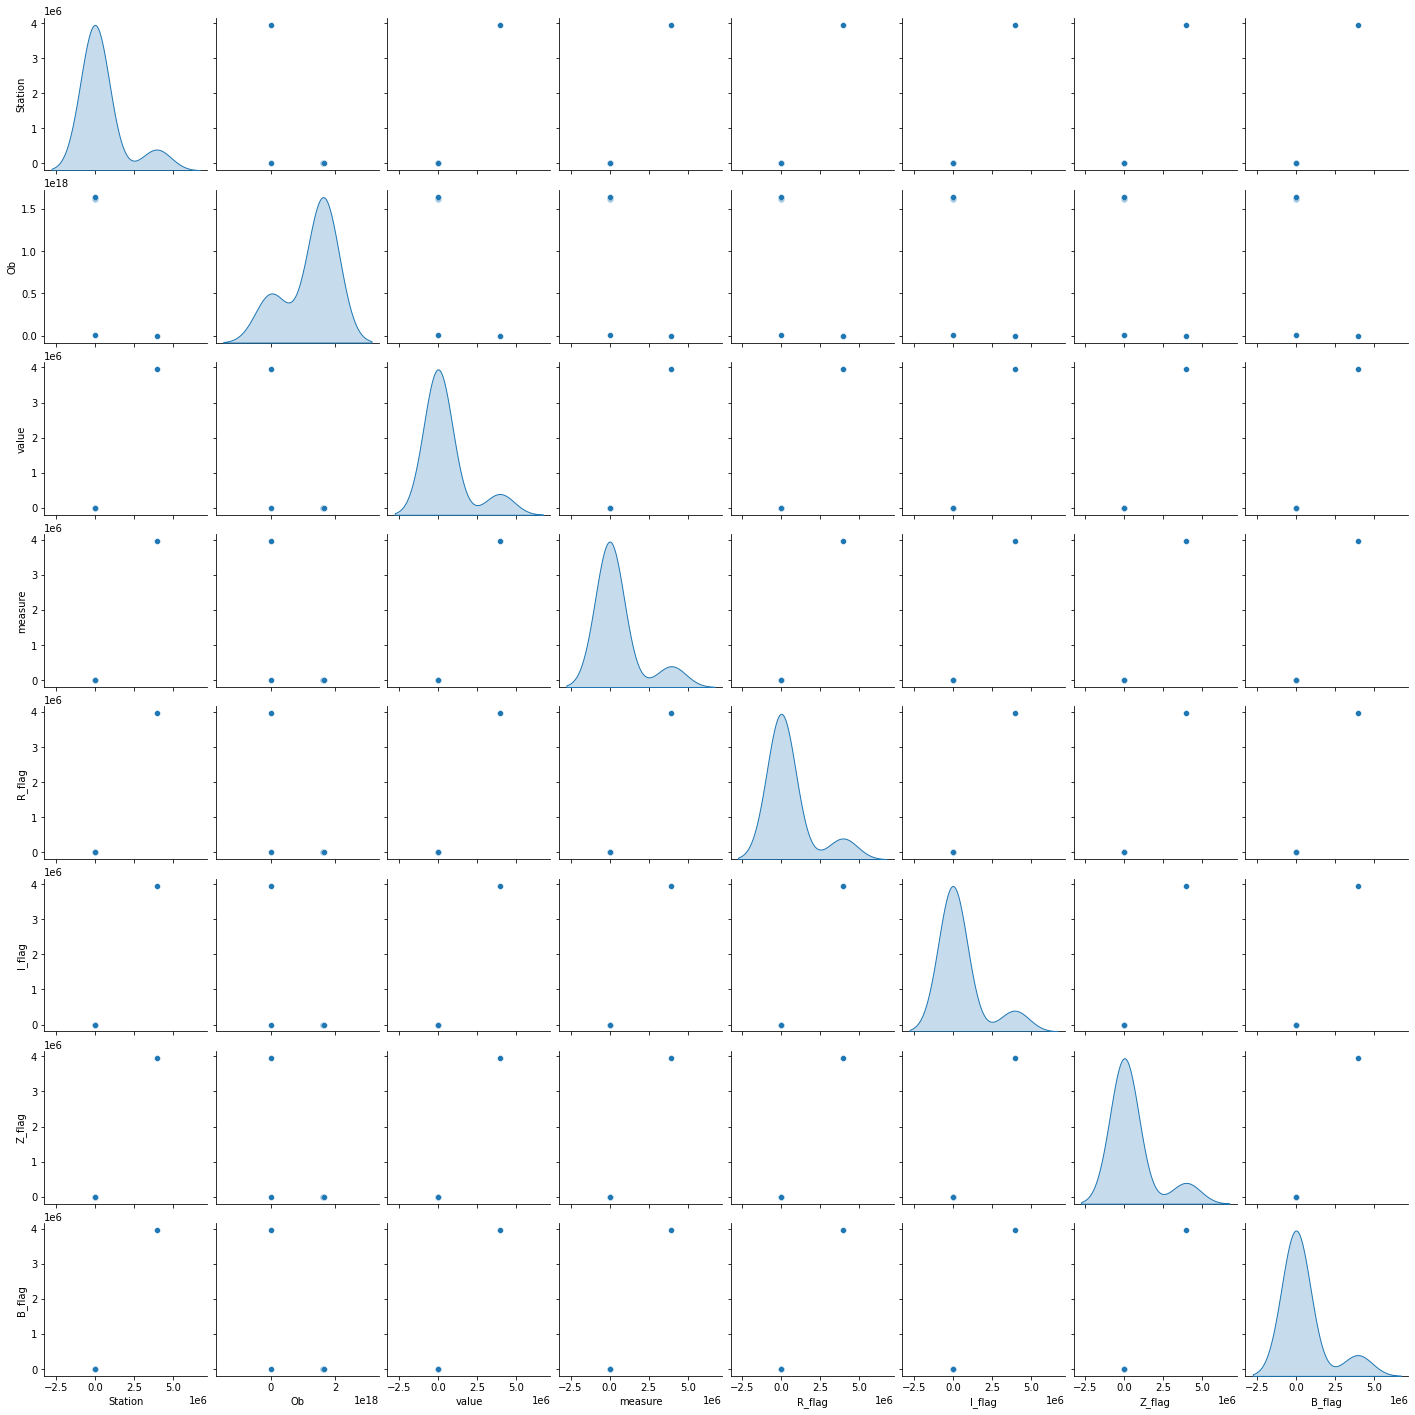

In [57]:
# Plot the relationship between each two variables to spot anything incorrect.
train_stats = train_dataset.describe()
train_stats.pop("target")
sns.pairplot(train_stats[train_stats.columns], diag_kind="kde") # or diag_kind='reg'

In [58]:
# Statistics on the train dataset to make sure it is in a good shape. (you may display the same stat for test and validate)
train_stats = train_dataset.describe()
train_stats.pop("target")
train_stats = train_stats.transpose()
train_stats

count          mean           std           min           25%  \
Station  3955964.0  2.020556e+01  1.282049e+01  0.000000e+00  9.000000e+00   
Ob       3955964.0  1.623849e+18  8.831865e+15  1.609459e+18  1.616735e+18   
value    3955964.0  2.421342e-04  1.000291e+00 -1.461748e+01 -8.172702e-01   
measure  3955964.0  8.560873e+00  2.546359e+00  0.000000e+00  8.000000e+00   
R_flag   3955964.0  5.217292e-01  1.154499e+00 -1.000000e+00  0.000000e+00   
I_flag   3955964.0 -5.988037e-01  1.002714e+00 -1.000000e+00 -1.000000e+00   
Z_flag   3955964.0 -7.828769e-01  6.346134e-01 -1.000000e+00 -1.000000e+00   
B_flag   3955964.0  5.416397e-01  1.062232e+00 -1.000000e+00 -1.000000e+00   

                  50%           75%           max  
Station  2.100000e+01  3.100000e+01  4.200000e+01  
Ob       1.624042e+18  1.630579e+18  1.639699e+18  
value   -2.842409e-01  8.391855e-01  4.362702e+01  
measure  8.000000e+00  9.000000e+00  1.500000e+01  
R_flag   0.000000e+00  0.000000e+00  4.000000e+00  
I_flag  -1.000000e+00 -1.000000e+00  4.000000e+00  
Z_flag  -1.000000e+00 -1.000000e+00  4.000000e+00  
B_flag   1.000000e+00  1.000000e+00  4.000000e+00

In [59]:
train_labels = train_dataset.pop('target')
test_labels = test_dataset.pop('target')
valid_labels = valid_dataset.pop('target')

In [60]:
# define a function to normalize the data set.
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_valid_dataset = norm(valid_dataset)

In [61]:
print(r'Train/Test/Validate splits: ')
print(f'Train    : {normed_train_data.shape} ')
print(f'Test     : {normed_test_data.shape} ')
print(f'Validate : {normed_valid_dataset.shape} ')

print(r'Train/Test/Validate labels: ')
print(f'Train Labels : {train_labels.shape} ')
print(f'Test Labels  : {test_labels.shape} ')
print(f'Test Labels  : {valid_labels.shape} ')

Train/Test/Validate splits: 
Train    : (3955964, 8) 
Test     : (1318655, 8) 
Validate : (1318655, 8) 
Train/Test/Validate labels: 
Train Labels : (3955964,) 
Test Labels  : (1318655,) 
Test Labels  : (1318655,) 


## 2. Normal Neural (with out LSTM) - just hidden layers.

In [62]:
# reshape the X_train and X_test to 3d array
normed_train_data = normed_train_data.values.reshape(normed_train_data.shape[0], normed_train_data.shape[1], 1)

In [63]:
# We decalred a function for creating a model.
def build_model1_two_hidden_layers():
    # Keras model object created from Sequential class. This will be the container that contains all layers.
    model = Sequential()

    # The model so far is empty. It can be constructed by adding layers and compilation.
    # This Keras model with multiple hidden layers.
    
    # Input Layer with 10 Neurons
    model.add(Dense(32, input_shape = (normed_train_data.shape[1],)))    # Input layer => input_shape must be explicitly designated
#     model.add(Activation('relu')) # relu or sigmoid.
    
#     model.add(Dense(128,Activation('relu')))                         # Hidden layer 1 => only output dimension should be designated (output dimension = # of Neurons = 50)
    
    
    
    
    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem
    
    # Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp, etc. # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    learning_rate = 0.0001
    optimizer = optimizers.SGD(learning_rate)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=optimizer,
                metrics=['accuracy']) # for regression problems, mean squared error (MSE) is often employed
    return model


EPOCHS = 5
batch_size = 512 # 6 iteration

model = build_model1_two_hidden_layers()
print('Here is a summary of this model: ')
model.summary()


with tf.device('/CPU:0'): # it can be with '/CPU:0'
# with tf.device('/GPU:0'): # comment the previous line and uncomment this line to train with a GPU, if available.
    history = model.fit(
        normed_train_data, 
        train_labels,
        batch_size = batch_size,
        epochs=EPOCHS, 
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
        validation_data = (normed_valid_dataset, valid_labels),   
    )

Here is a summary of this model: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
7726/7726 [==============================] - 12s 2ms/step - loss: 0.5382 - accuracy: 0.9398 - val_loss: 0.4109 - val_accuracy: 0.9639
Epoch 2/5
7726/7726 [==============================] - 11s 1ms/step - loss: 0.3381 - accuracy: 0.9642 - val_loss: 0.2818 - val_accuracy: 0.9645
Epoch 3/5
7726/7726 [==============================] - 12s 2ms/step - loss: 0.2471 - accuracy: 0.9643 - val_loss: 0.2191 - val_acc

In [64]:
print('Summary of the results after each epoch: ')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Summary of the results after each epoch: 


loss  accuracy  val_loss  val_accuracy  epoch
0  0.538236  0.939769  0.410864      0.963945      0
1  0.338133  0.964203  0.281780      0.964483      1
2  0.247111  0.964270  0.219132      0.964482      2
3  0.201003  0.964266  0.185695      0.964482      3
4  0.175430  0.964263  0.166287      0.964482      4

In [65]:
print('Train Split: ')
loss, accuracy = model.evaluate(normed_train_data, train_labels, verbose=1)

print("Accuracy   : {:5.2f} ".format(accuracy))

Train Split: 
123624/123624 [==============================] - 177s 1ms/step - loss: 0.1666 - accuracy: 0.9643
Accuracy   :  0.96 


In [66]:
print('Evaluation Split: ')
loss, accuracy =  model.evaluate(normed_valid_dataset, valid_labels, verbose=2)

print("Accuracy   : {:5.2f} ".format(accuracy))

Evaluation Split: 
41208/41208 - 30s - loss: 0.1663 - accuracy: 0.9645 - 30s/epoch - 733us/step
Accuracy   :  0.96 


In [67]:
print('Test Split: ')
loss, accuracy =  model.evaluate(normed_test_data, test_labels, verbose=2)

print("Accuracy   : {:5.2f} ".format(accuracy))

Test Split: 
41208/41208 - 33s - loss: 0.1663 - accuracy: 0.9644 - 33s/epoch - 804us/step
Accuracy   :  0.96 


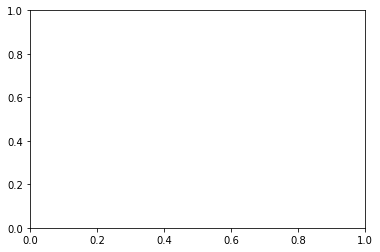

In [68]:
ax= plt.subplot()
predict_results = model.predict(normed_test_data)

predict_results = (predict_results > 0.5)

C:\Users\vchalla2\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vchalla2\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vchalla2\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

              precision    recall  f1-score   support

           0       0.96      1.00      0.98   1271695
           1       0.00      0.00      0.00     46960

    accuracy                           0.96   1318655
   macro avg       0.48      0.50      0.49   1318655
weighted avg       0.93      0.96      0.95   1318655

Accuracy: 0.96438795590962
F-2 Score: 0.0
Neural Network with Dense layers: f1=0.000 auc=0.518


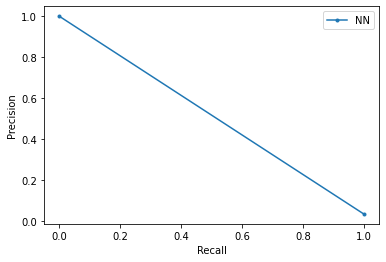

In [69]:
from sklearn.metrics import roc_curve, auc,accuracy_score

print(classification_report(test_labels, predict_results))
print("Accuracy: " + str( accuracy_score(test_labels, predict_results)))
from sklearn.metrics import fbeta_score
print("F-2 Score: "+ str(fbeta_score(test_labels, predict_results,beta=2)))


# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(test_labels, predict_results)
lr_f1, lr_auc = f1_score(test_labels, predict_results), auc(lr_recall, lr_precision)
# summarize scores
print('Neural Network with Dense layers: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# Can input diffrent models curves just as above code
pyplot.plot(lr_recall, lr_precision, marker='.', label='NN')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## 3. LSTM

In [70]:
#smote 
from imblearn.over_sampling import SMOTE
X = df.drop('target',axis='columns')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [71]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5274619, 8)
(1318655, 8)
(5274619,)
(1318655,)


In [72]:
# reshape the X_train and X_test to 3d array
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)


In [73]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5274619, 8, 1)
(1318655, 8)
(5274619,)
(1318655,)


In [74]:
# Building LSTM model

model = Sequential()
model.add(LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
EPOCHS = 5
batch_size = 512 # 6 iteration

print('Here is a summary of this model: ')
model.summary()

Here is a summary of this model: 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [75]:

with tf.device('/CPU:0'): # it can be with '/CPU:0'
# with tf.device('/GPU:0'): # comment the previous line and uncomment this line to train with a GPU, if available.
    history = model.fit(
        X_train, 
        y_train,
        batch_size = 2048,
        epochs=EPOCHS, 
        verbose=1,
        shuffle=True,
        #steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
        validation_data = (X_test, y_test)  
    )

Epoch 1/5
2576/2576 [==============================] - 49s 18ms/step - loss: 0.1606 - accuracy: 0.9558 - val_loss: 0.1238 - val_accuracy: 0.9643
Epoch 2/5
2576/2576 [==============================] - 46s 18ms/step - loss: 0.0996 - accuracy: 0.9672 - val_loss: 0.0758 - val_accuracy: 0.9715
Epoch 3/5
2576/2576 [==============================] - 45s 17ms/step - loss: 0.0646 - accuracy: 0.9787 - val_loss: 0.0607 - val_accuracy: 0.9806
Epoch 4/5
2576/2576 [==============================] - 43s 17ms/step - loss: 0.0591 - accuracy: 0.9803 - val_loss: 0.0567 - val_accuracy: 0.9808
Epoch 5/5
2576/2576 [==============================] - 45s 17ms/step - loss: 0.0538 - accuracy: 0.9814 - val_loss: 0.0522 - val_accuracy: 0.9831


In [76]:
y_test_pred = model.predict(X_test)
predicted_results = [1 if i > 0.5 else 0 for i in y_test_pred]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1271621
           1       0.81      0.69      0.74     47034

    accuracy                           0.98   1318655
   macro avg       0.90      0.84      0.87   1318655
weighted avg       0.98      0.98      0.98   1318655

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1271621
           1       0.81      0.69      0.74     47034

    accuracy                           0.98   1318655
   macro avg       0.90      0.84      0.87   1318655
weighted avg       0.98      0.98      0.98   1318655

Accuracy: 0.9830562201637274
F-2 Score: 0.7091987220223251
Neural Network with Dense layers: f1=0.743 auc=0.754


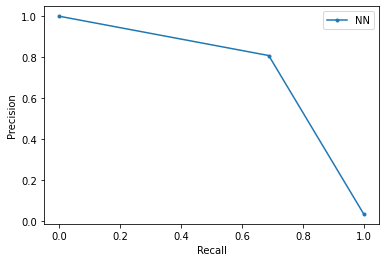

In [78]:
from sklearn.metrics import roc_curve, auc,accuracy_score

print(classification_report(y_test, predicted_results))
print(classification_report(y_test, predicted_results))
print("Accuracy: " + str( accuracy_score(y_test, predicted_results)))
from sklearn.metrics import fbeta_score
print("F-2 Score: "+ str(fbeta_score(y_test, predicted_results,beta=2)))


# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(y_test, predicted_results)
lr_f1, lr_auc = f1_score(y_test, predicted_results), auc(lr_recall, lr_precision)
# summarize scores
print('Neural Network with Dense layers: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# Can input diffrent models curves just as above code
pyplot.plot(lr_recall, lr_precision, marker='.', label='NN')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Predictions on the test file.
This section makes the predictions on the test file.

In [79]:
weather_data_test = pd.read_csv('C:/Users/vchalla2/Downloads/ECONet/test.csv')
df_test = weather_data_test
#Encoding non-traditional features
df_test.Station = le.fit_transform(df_test.Station)
df_test.measure = le.fit_transform(df_test.measure)
#converting time series to numeric and performed encoding on station,measure 
df_test['Ob'] = pd.to_numeric(pd.to_datetime(df_test['Ob']))
df_test.value = scaling.fit_transform(df_test[['value']])
normalized_test = df_test[{'value', 'measure'}].groupby('measure').transform(lambda x: (x - x.mean()) / x.std())
df_test.value = normalized_test['value']
df_test['value'].fillna(0, inplace=True)
df_test['measure'].fillna(0, inplace=True)
df_test['Ob'].fillna(0, inplace=True)
df_test

C:\Users\vchalla2\AppData\Local\Temp\ipykernel_14208\907279357.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  normalized_test = df_test[{'value', 'measure'}].groupby('measure').transform(lambda x: (x - x.mean()) / x.std())


Station                   Ob     value  measure  R_flag  I_flag  \
0              0  1616668620000000000  1.372092       14       2      -1   
1              0  1626009720000000000  1.845918       14       2      -1   
2              0  1626009780000000000  1.845918       14       2      -1   
3              0  1626009840000000000  1.845918       14       2      -1   
4              0  1626009900000000000  1.852686       14       2      -1   
...          ...                  ...       ...      ...     ...     ...   
1856101       42  1619049360000000000 -1.515628        0       4      -1   
1856102       42  1619049420000000000 -1.515628        0       4      -1   
1856103       42  1619049480000000000 -1.552547        0       4      -1   
1856104       42  1619049540000000000 -1.552547        0       4      -1   
1856105       42  1619049600000000000 -1.552547        0       4      -1   

         Z_flag  B_flag  
0             2       0  
1             0       1  
2             0       1  
3             0       1  
4             0       1  
...         ...     ...  
1856101      -1      -1  
1856102      -1      -1  
1856103      -1      -1  
1856104      -1      -1  
1856105      -1      -1  

[1856106 rows x 8 columns]

In [80]:
# y_pred = model.predict_proba(df_test)
y_pred=model.predict(df_test)

In [81]:
# Make sure you modify the path according to the your local target.
pd.DataFrame(y_pred, columns=['target']).to_csv('C:/Users/vchalla2/Downloads/ECONet/lstm.csv', index=False)